In [7]:
# =========================
# 0) Imports & config
# =========================
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Edit these paths to your summary CSVs
CSV_PATHS = {
    "Baseline": "baselines_all_best/baselines_summary.csv",
    "DCA":      "dca_full/dca_summary.csv",
    "scVI":     "scvi_full/scvi_summary.csv",
    # Optional: add refit results at matched HVG (recommended)
    "scVI_refit": "results/scvi_refit/scvi_refit_all.csv",   # change or remove if not available
}

# Choose metrics that exist in your CSVs
ERROR_ZERO = ["MAE_zero", "MSE_zero", "MedianL1_zero", "NB_ll_zero", "NB_dev_zero"]
ERROR_THIN = ["MAE_thin", "MSE_thin", "MedianL1_thin", "NB_ll_thin", "NB_dev_thin"]
STRUCTURE  = ["Silhouette"]   # add "spearman_gene_corr" if you computed it

# Preferred HVG for apples-to-apples comparison (adjust)
TARGET_HVG = 2000

# Plot style
sns.set(style="whitegrid", context="talk")


In [8]:
# =========================
# 1) Load + harmonize
# =========================
def load_with_source(path: str | Path, source: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["source"] = source
    # If 'model' is missing, use source as model; otherwise keep provided model names
    df["model"] = df["model"] if "model" in df.columns else df["source"]
    return df

dfs = []
for name, p in CSV_PATHS.items():
    p = Path(p)
    if p.exists():
        dfs.append(load_with_source(p, name))
    else:
        print(f"[warn] Missing file for {name}: {p}")

if not dfs:
    raise FileNotFoundError("No CSVs found. Check CSV_PATHS.")

df = pd.concat(dfs, ignore_index=True)

# Unify HVG column
if "n_hvg" not in df.columns:
    if "hvg" in df.columns:
        df["n_hvg"] = df["hvg"]
    elif "n_genes" in df.columns:
        df["n_hvg"] = df["n_genes"]
    else:
        df["n_hvg"] = np.nan
df["n_hvg"] = pd.to_numeric(df["n_hvg"], errors="coerce").astype("Int64")

# Make sure metrics are numeric where present
for col in set(ERROR_ZERO + ERROR_THIN + STRUCTURE):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep TEST rows if your files contain "set" (comment out if already aggregated)
if "set" in df.columns:
    df = df[df["set"].astype(str).str.lower().eq("test") | df["set"].isna()].copy()

# Normalize model labels a bit
df["model"] = df["model"].astype(str)
df.loc[df["model"].str.lower().str.contains("raw"), "model"] = "Raw"
df.loc[df["model"].str.lower().str.contains("mean"), "model"] = "Mean"
df.loc[df["model"].str.lower().str.contains("median"), "model"] = "Median"
df.loc[df["model"].str.lower().str.contains("knn"), "model"] = "KNN"
df.loc[df["source"].str.lower().eq("dca"), "model"] = "DCA"
df.loc[df["source"].str.lower().eq("scvi"), "model"] = "scVI"
df.loc[df["source"].str.lower().str.contains("refit"), "model"] = "scVI (refit)"

display(df.head())
print("Models:", sorted(df["model"].dropna().unique()))
print("HVG sizes:", sorted(df["n_hvg"].dropna().unique()))


[warn] Missing file for scVI_refit: results/scvi_refit/scvi_refit_all.csv


,model,n_hvg,MAE_zero,MSE_zero,MedianL1_zero,NB_ll_zero,NB_dev_zero,MAE_thin,MSE_thin,MedianL1_thin,NB_ll_thin,NB_dev_thin,Silhouette,params,source
0,KNN,2000,160.705153,4.431040e+06,6.374074,-8.509962,8.398962,0.852948,36.637552,0.000000,-1.168131,0.658696,NaN,"{'n_neighbors': 36, 'weights': 'uniform'}",Baseline
1,MAGIC,2000,391.820482,7.278395e+07,6.032036,-5.033396,1.445831,5.427325,4093.832397,0.175030,-0.960799,0.271642,NaN,"{'knn': 5, 'n_pca': 30, 't': 2}",Baseline
2,Mean,2000,450.904811,4.780094e+07,8.908444,-4.595289,0.569616,23.240607,237053.997457,0.378265,-1.051061,0.452167,NaN,{},Baseline
3,Median,2000,439.363050,4.895885e+07,4.633333,-inf,634.094426,21.776859,234415.413433,0.000000,-15.003645,27.880623,NaN,{},Baseline
4,DCA,2000,140.469869,6.946264e+06,1.998560,-4.398858,0.176755,7.171667,42724.766382,0.041514,-0.906699,0.163444,NaN,"{'batch_size': 64, 'epochs': 300, 'hidden_size...",DCA


Models: ['DCA', 'KNN', 'MAGIC', 'Mean', 'Median', 'scVI']
HVG sizes: [np.int64(800), np.int64(2000)]


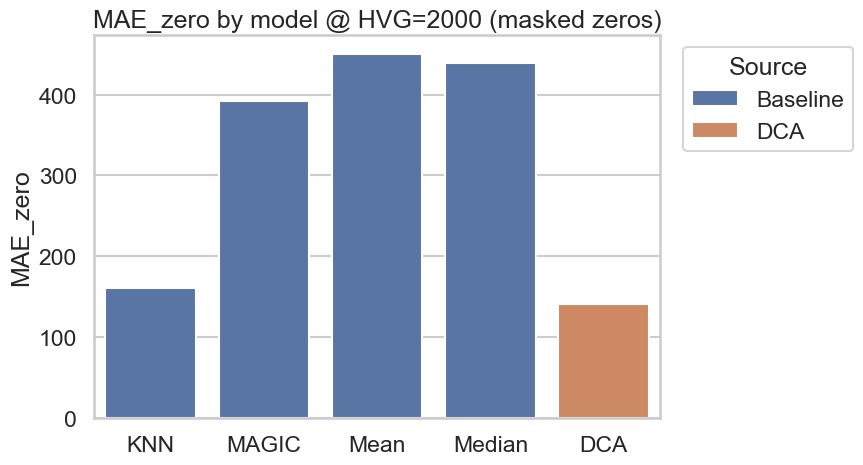

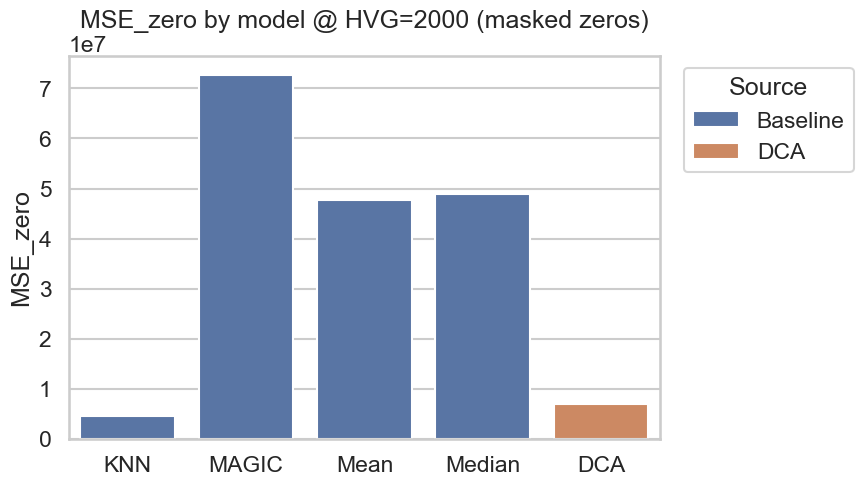

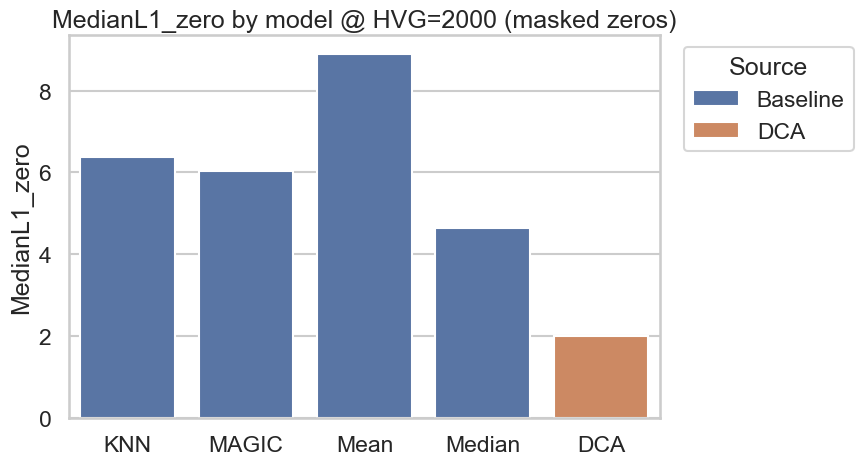

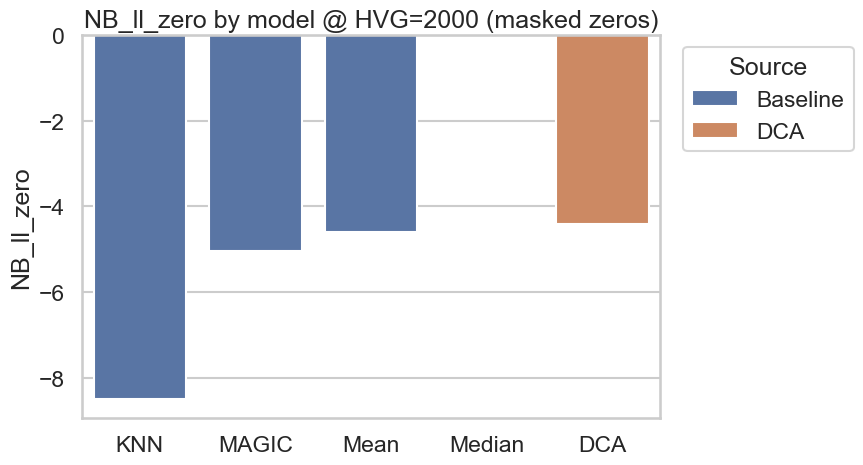

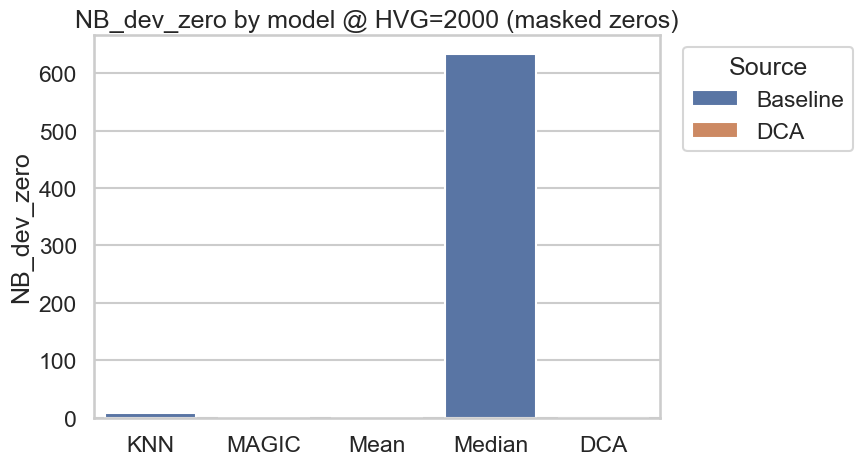

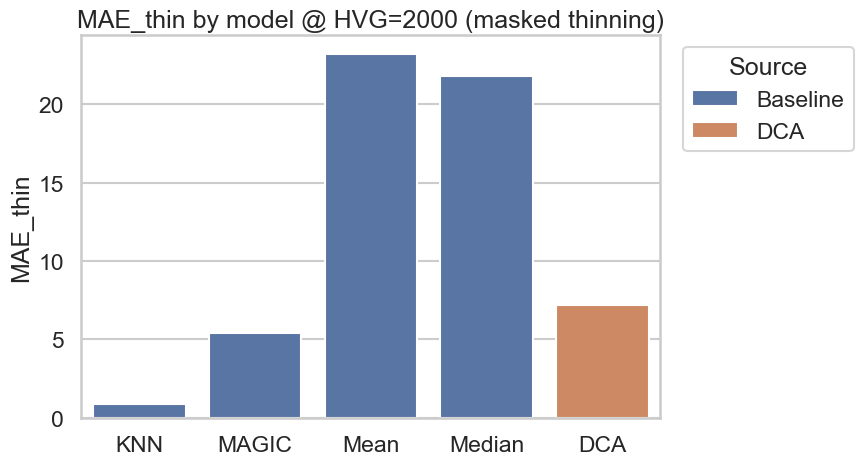

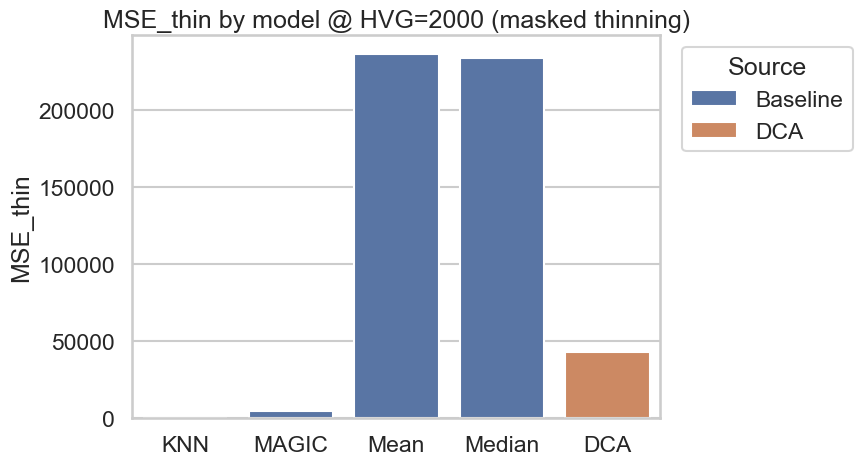

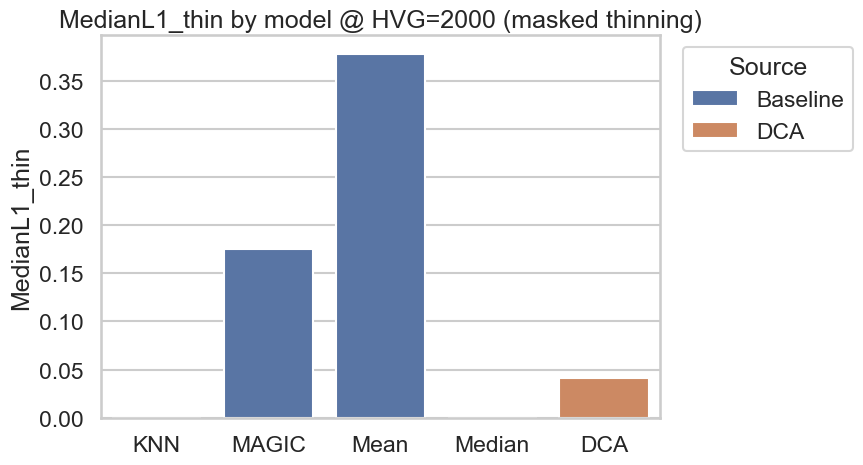

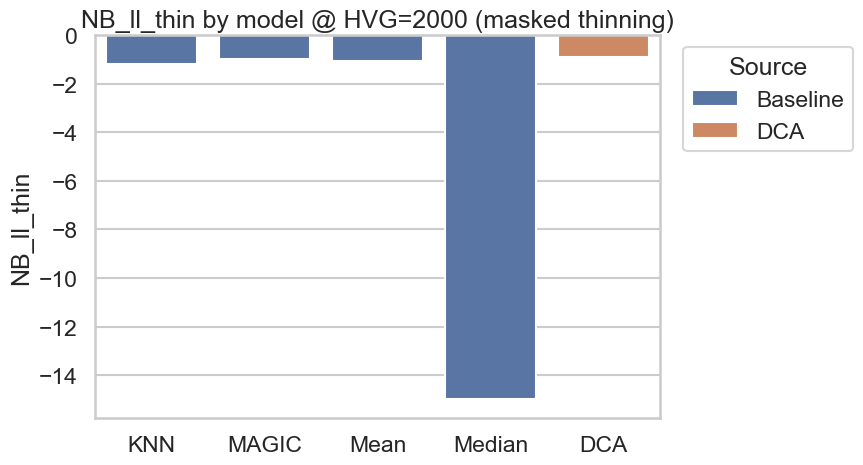

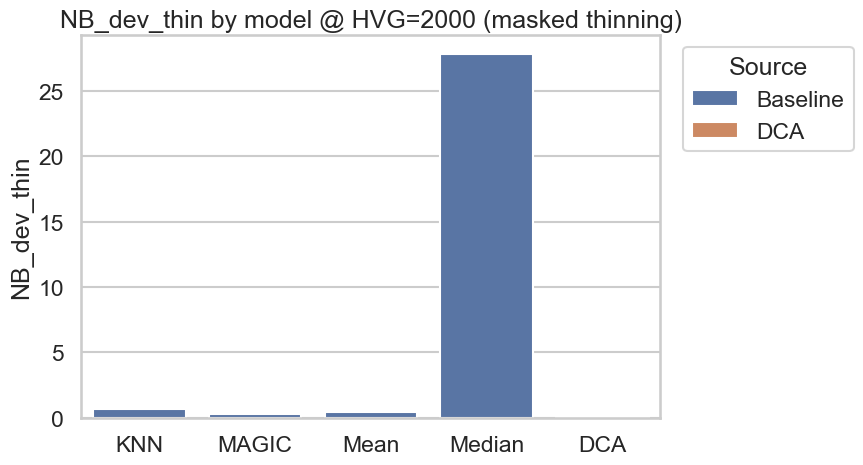

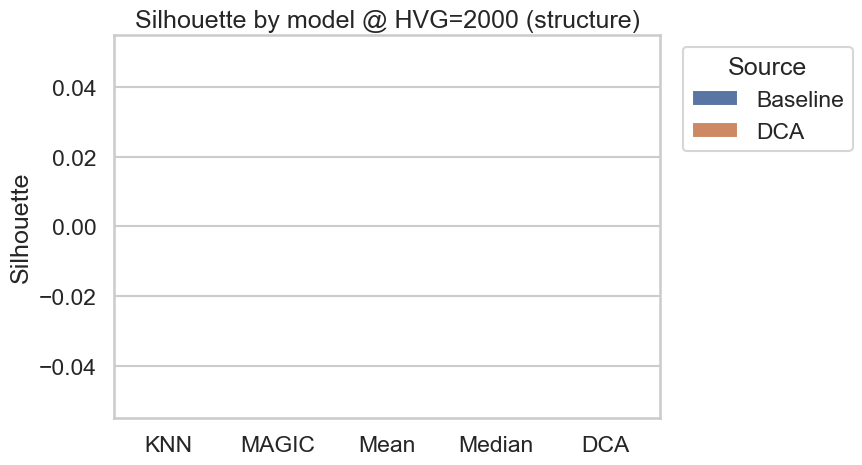

In [9]:
# =========================
# 2) Bar charts at chosen HVG
# =========================
df_target = df[df["n_hvg"] == TARGET_HVG].copy()
if df_target.empty:
    print(f"[warn] No rows at n_hvg={TARGET_HVG}; plotting across all HVGs instead.")
    df_target = df.copy()

def barblock(metrics: list, title_suffix: str):
    use = [m for m in metrics if m in df_target.columns]
    if not use:
        print(f"[warn] No metrics from {metrics} found to plot.")
        return
    for m in use:
        plt.figure(figsize=(9,5))
        ax = sns.barplot(data=df_target, x="model", y=m, hue="source", errorbar="sd")
        ax.set_title(f"{m} by model @ HVG={TARGET_HVG} {title_suffix}")
        ax.set_xlabel("")
        ax.set_ylabel(m)
        plt.xticks(rotation=0)
        plt.legend(title="Source", bbox_to_anchor=(1.02,1), loc="upper left")
        plt.tight_layout(); plt.show()

# Masked zeros (error)
barblock(ERROR_ZERO, "(masked zeros)")

# Masked thinning (error)
barblock(ERROR_THIN, "(masked thinning)")

# Structure metrics (e.g., Silhouette)
barblock(STRUCTURE, "(structure)")


In [10]:
# =========================
# 3) Trade-off scatter (error vs structure)
# =========================
# Choose one structure metric that exists
structure_metric = next((m for m in ["Silhouette", "spearman_gene_corr"] if m in df.columns and df[m].notna().any()), None)
if structure_metric is None:
    print("[info] No structure metric available; skipping trade-off plots.")
else:
    # Pick representative errors to visualize trade-off
    candidate_errors = [m for m in ["MSE_zero","MAE_zero","NB_dev_zero","MSE_thin","MAE_thin","NB_dev_thin"] if m in df.columns]
    for em in candidate_errors:
        plt.figure(figsize=(8,6))
        ax = sns.scatterplot(
            data=df, x=em, y=structure_metric,
            hue="model", style="n_hvg", s=90, alpha=0.9
        )
        ax.set_title(f"Trade-off: {em} vs {structure_metric}")
        ax.set_xlabel(em); ax.set_ylabel(structure_metric)
        plt.legend(title="Model / HVG", bbox_to_anchor=(1.02,1), loc="upper left")
        plt.tight_layout(); plt.show()


[info] No structure metric available; skipping trade-off plots.


In [11]:
# =========================
# 4) Per-fold boxplots (optional, if 'fold' exists)
# =========================
if "fold" in df.columns:
    for m in [c for c in ERROR_ZERO + ERROR_THIN if c in df.columns]:
        plt.figure(figsize=(10,5))
        ax = sns.boxplot(data=df[df["n_hvg"]==TARGET_HVG], x="model", y=m)
        ax.set_title(f"{m} distribution across folds @ HVG={TARGET_HVG}")
        ax.set_xlabel(""); ax.set_ylabel(m)
        plt.tight_layout(); plt.show()


In [12]:
# =========================
# 5) Composite ranking (lower error + higher structure)
# =========================
def composite_rank(dfin: pd.DataFrame, err_col: str, struct_col: str, hvg: int, w_err=0.5, w_struct=0.5):
    sub = dfin[(dfin["n_hvg"]==hvg) & dfin[err_col].notna()].copy()
    if struct_col not in sub.columns or sub[struct_col].isna().all():
        print("[info] Structure metric missing or empty; ranking by error only.")
        sub["score"] = (sub[err_col] - sub[err_col].min())/(sub[err_col].max()-sub[err_col].min() + 1e-12)
    else:
        e = sub[err_col]; s = sub[struct_col]
        e_norm = (e - e.min())/(e.max()-e.min() + 1e-12)             # lower is better
        s_norm = (s.max()-s)/(s.max()-s.min() + 1e-12)               # higher is better
        sub["score"] = w_err*e_norm + w_struct*s_norm
    return sub.sort_values("score")

# Example: rank with MSE_zero and Silhouette @ TARGET_HVG
if "MSE_zero" in df.columns:
    rank = composite_rank(df, "MSE_zero", structure_metric or "Silhouette", TARGET_HVG, w_err=0.5, w_struct=0.5)
    cols = ["model","source","n_hvg","MSE_zero"]
    if structure_metric and structure_metric in rank.columns: cols.append(structure_metric)
    cols.append("score")
    display(rank[cols].head(10))


[info] Structure metric missing or empty; ranking by error only.


,model,source,n_hvg,MSE_zero,score
0,KNN,Baseline,2000,4.431040e+06,0.000000
4,DCA,DCA,2000,6.946264e+06,0.036798
2,Mean,Baseline,2000,4.780094e+07,0.634500
3,Median,Baseline,2000,4.895885e+07,0.651440
1,MAGIC,Baseline,2000,7.278395e+07,1.000000
